# Week 3 Pitch

### Goal: Develop an app predicting waiting time until getting a good solution to user question on Stack overflow

### Value: Help manage time expectation and guide how to best post a question to get the best answer

### Source:  https://archive.org/download/stackexchange

### Tools used: networkx, sklearn, pandas, numpy

### Steps: 
#### 1. Processed stackoverflow.com-Posts.7z from https://archive.org/download/stackexchange (62G)

In [43]:
import dill
import operator
import os
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

os.chdir('/home/vagrant/projects/stackoverflow-post')
df = dill.load(open('data/df.pkd', 'r'))
df.head()

,fa_score,fa_time,q_body,q_body_len,q_date,q_owner,q_score,q_tag,q_title,s10_time,s20_time,s50_time,s5_time
0,4.0,434.554,<p>I am thinking along the lines of replicatin...,367,2008-09-19 05:09:25.977,essexboyracer,0,<php>,Convert/extract phpinfo() into php.ini,NaN,NaN,NaN,NaN
1,2.0,11504.657,<p>Has anyone any reources for learning how to...,402,2008-09-24 06:42:46.107,essexboyracer,2,<php><mysql><svg><vector-graphics><php-gtk>,Interactive SVG - Learning Resources?,NaN,NaN,NaN,NaN
2,1.0,1630433.760,<p>I'm trying to decode a WBXML encoded SyncML...,632,2008-10-22 15:25:00.777,11542,1,<python><s60><syncml><wbxml>,Decoding a WBXML SyncML message from an S60 de...,NaN,NaN,NaN,NaN
3,110.0,5496.290,<p>I want to get the headers only from a curl ...,401,2008-11-13 14:00:43.840,11542,30,<curl>,Curl post data and headers only,5496.29,5496.29,5496.29,5496.29
4,NaN,NaN,<p>I'm just starting to try out phpunit on som...,651,2008-11-14 10:37:13.877,11542,7,<php><unit-testing><phpunit>,PHPUnit filenaming conventions,NaN,NaN,NaN,NaN


#### 2. Collected Attributes for each posts
##### a. Tags (top 20 below)

In [20]:
df_tag = dill.load(open('data/df_tag.pkd', 'r'))
tag_count = dict()
for tag in df.q_tag:
    li = tag.split('><')
    for j in li:
        j = j.replace('<', '')
        j = j.replace('>', '')
        if j not in tag_count:
            tag_count[j] = 1
        else:
            tag_count[j] += 1
sortedTags = sorted(tag_count.items(), key = operator.itemgetter(1), reverse = True)
selectedTags = {k:v for k,v in sortedTags if v>=len(df)*0.01} 
selectedTags

{'.net': 10512,
 'ajax': 1185,
 'algorithm': 1108,
 'asp.net': 7212,
 'asp.net-mvc': 1959,
 'c': 2207,
 'c#': 15092,
 'c++': 5771,
 'css': 1873,
 'database': 2131,
 'html': 2724,
 'iphone': 1681,
 'java': 7855,
 'javascript': 5307,
 'jquery': 2319,
 'linq': 1177,
 'linux': 1517,
 'multithreading': 1176,
 'mysql': 2279,
 'performance': 1524,
 'php': 4458,
 'python': 4005,
 'regex': 1325,
 'ruby': 1697,
 'ruby-on-rails': 1660,
 'security': 1098,
 'sql': 3857,
 'sql-server': 3658,
 'svn': 1236,
 'unit-testing': 1109,
 'vb.net': 1799,
 'visual-studio': 2081,
 'visual-studio-2008': 1424,
 'web-services': 1170,
 'windows': 2554,
 'winforms': 1706,
 'wpf': 1867,
 'xml': 1737}

In [21]:
top10 = [n for (n,v) in sortedTags[0:10]]
def Cat(r, o):
    result = []
    for name in top10:
        d = dict()
        if r[name] == 1:
            d['Category'] = name
            d[o] = r['value']
            result.append(d)
    return result
def renderData_byOutcome(outcome):
    meltTop10 = pd.melt(df_tag, id_vars=top10, value_vars=outcome, var_name = outcome)
    pairs = meltTop10.apply(lambda row: Cat(row, outcome), axis = 1)
    plot_data = pd.DataFrame([e for li in pairs for e in li])
    plot_df = pd.DataFrame(plot_data)
    return plot_df
def rank_byTag(data, outcome):
    return data.groupby('Category')[outcome].mean().sort_values(ascending = False)
def boxplot_byTag(data, outcome):
    sortList = list(data.groupby('Category')[outcome].mean().sort_values(ascending = False).index)
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_xlabel('Top 10 Tags')
    ax.set_ylabel(outcome)
    ax.set_title('')
    data['Category'] = pd.Categorical(data['Category'], sortList)
    data = data.sort_values(by='Category', ascending = False)
    data.boxplot(column = outcome, by = 'Category', ax = ax)   
    plt.show()

plotData = renderData_byOutcome('fa_time')
rank_byTag(plotData, 'fa_time')

Category
.net          212830.716066
java          194630.823648
asp.net       194250.605056
sql-server    184722.852948
python        151174.067369
javascript    146716.899223
c#            145209.555426
php           108792.954735
c++           101422.547714
sql            73946.241155
Name: fa_time, dtype: float64

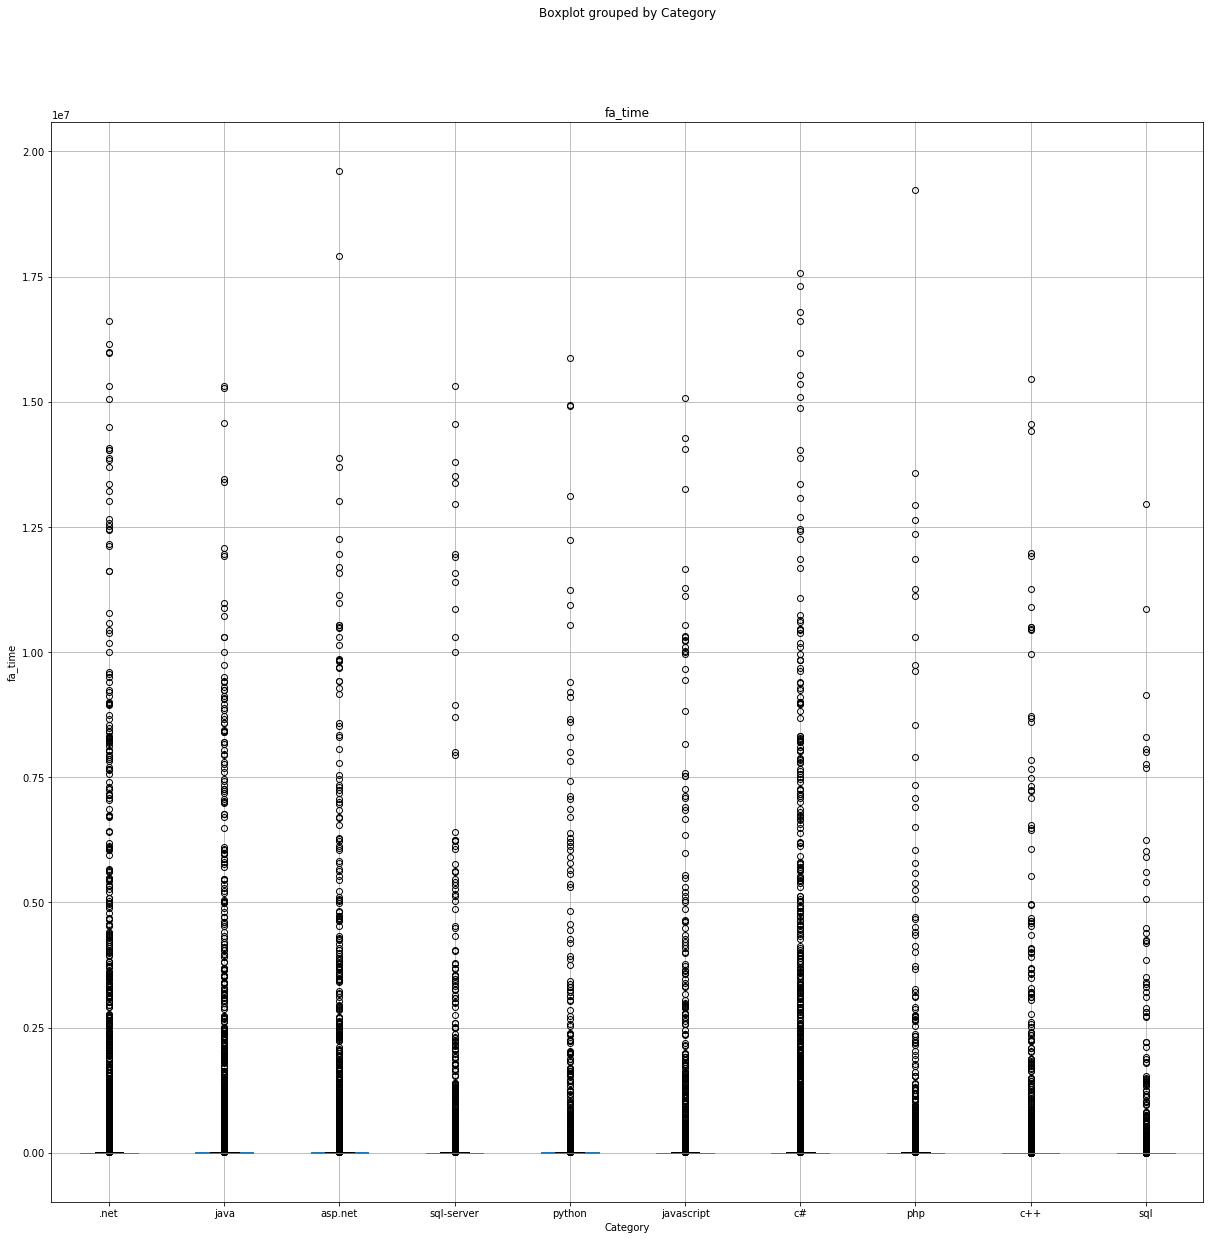

In [22]:
boxplot_byTag(plotData, 'fa_time')

##### b. User Network Characteristic: (In- / Out-) Degree, Centrality (# of nodes connected/#of nodes in total)

In [44]:
G = dill.load(open('G.pkd', 'r'))
centrality = dill.load(open('centrality.pkd', 'r'))
neighbors = [i for i in nx.all_neighbors(G, '40361')] 

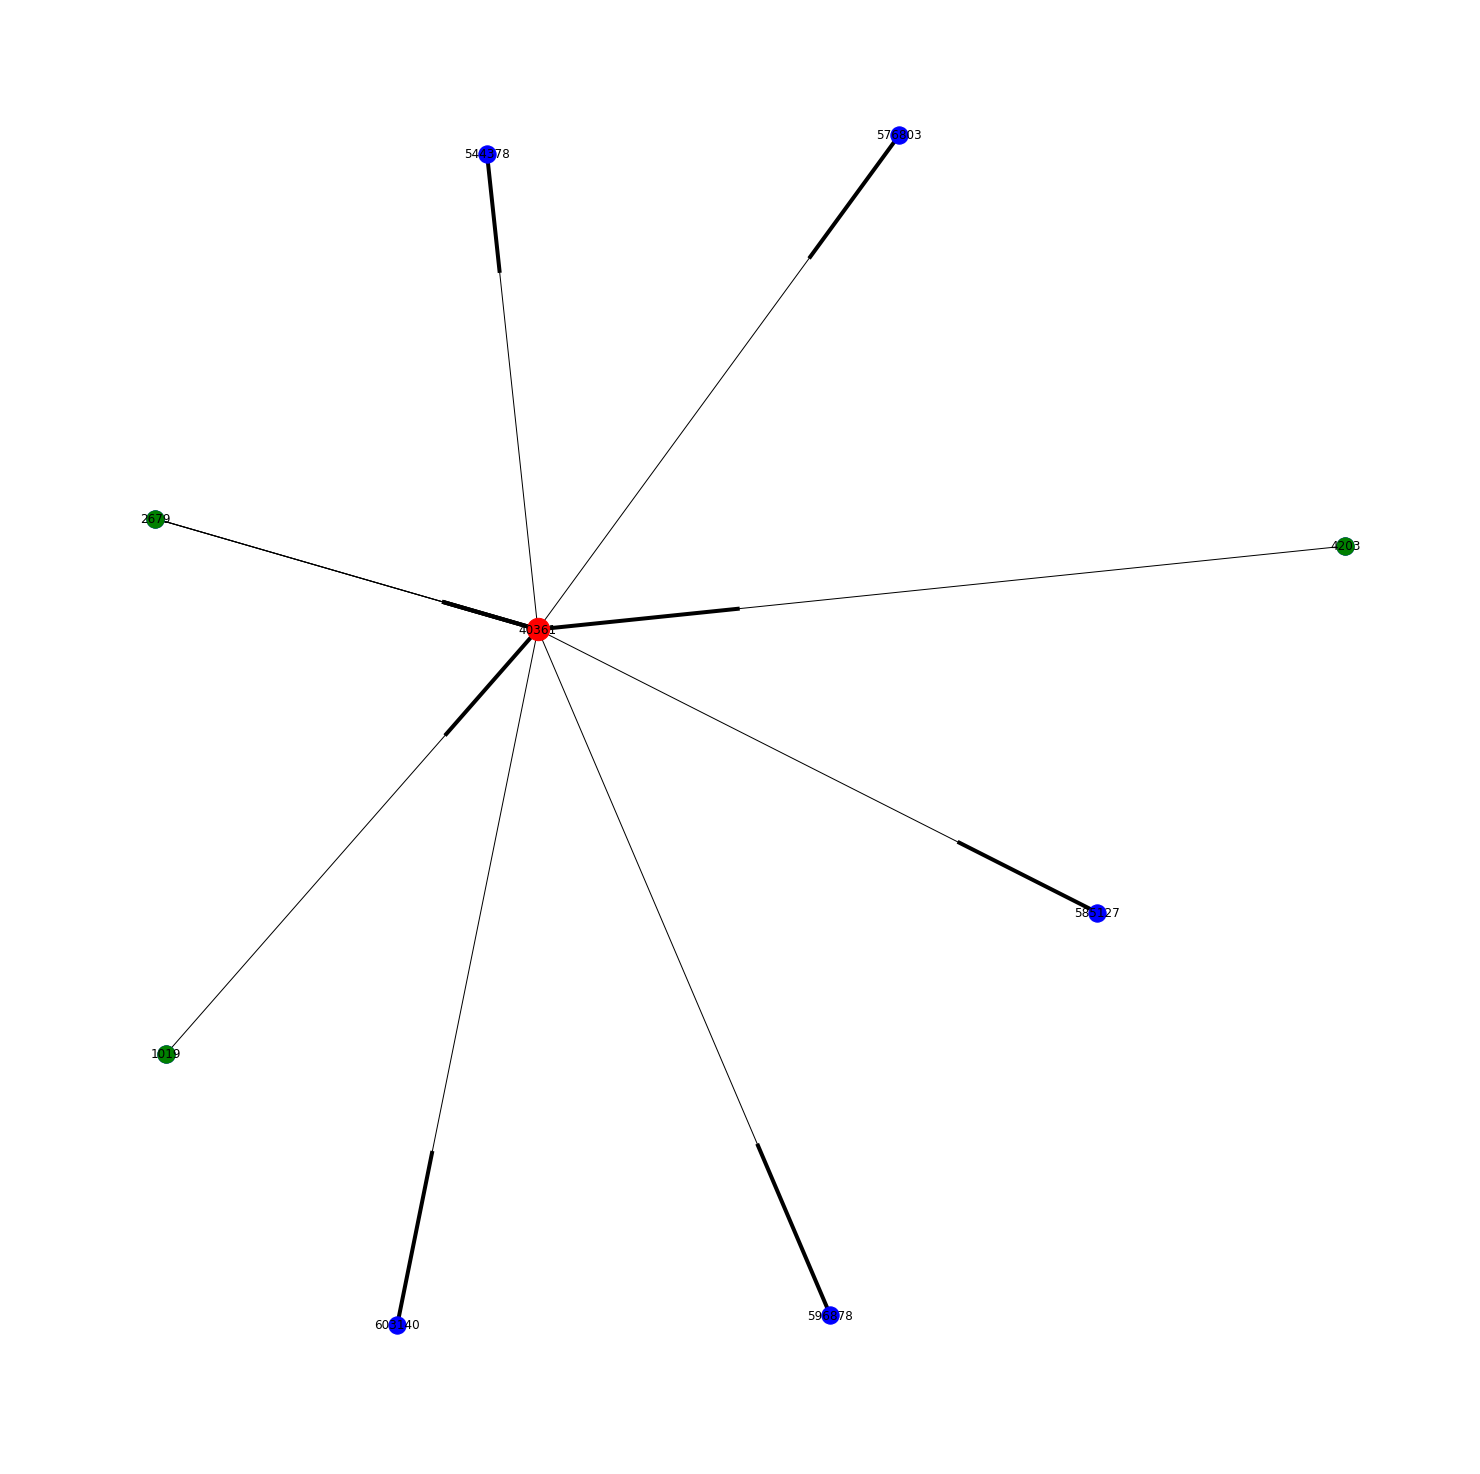

In [47]:
plt.figure(figsize=(20,20))
ego = nx.ego_graph(G, '40361', undirected = True)
pos = nx.spring_layout(ego)
nx.draw(ego, pos, node_color='b', node_size = 300, with_labels = True)
nx.draw_networkx_nodes(ego, pos, nodelist = ['40361'], node_size = 500, node_color='r')
nx.draw_networkx_nodes(ego, pos, nodelist = ['1019', '4203', '2679'], node_size = 300, node_color='g')
plt.show()

##### b. User Network Characteristic: (In- / Out-) Degree, Centrality (# of nodes connected/#of nodes in total)

In [13]:
#sort by degree centrality
centrality.sort_values(by='degree centrality', ascending = False).head()

,degree,in degree,out degree,degree centrality,in degree centrality,out degree centrality,allN,outN,inN,avg_n_contact,avg_n_in_contact,avg_n_out_contact
22656,2616,0,2616,0.017860,0.000000,0.017860,2592,2592,0,1.009259,NaN,1.009259
23354,2050,0,2050,0.013996,0.000000,0.013996,2027,2027,0,1.011347,NaN,1.011347
12950,1534,0,1534,0.010473,0.000000,0.010473,1529,1529,0,1.003270,NaN,1.003270
3043,1395,0,1395,0.009524,0.000000,0.009524,1360,1360,0,1.025735,NaN,1.025735
10661,1105,2,1103,0.007544,0.000014,0.007531,1088,1086,2,1.015625,1.0,1.015654


In [14]:
#max is 7 interactions per user with another node
centrality.sort_values(by='avg_n_contact', ascending = False).head()

,degree,in degree,out degree,degree centrality,in degree centrality,out degree centrality,allN,outN,inN,avg_n_contact,avg_n_in_contact,avg_n_out_contact
528519,7,7,0,0.000048,0.000048,0.000000,1,0,1,7.000000,7.000000,NaN
Kociub,6,0,6,0.000041,0.000000,0.000041,1,1,0,6.000000,NaN,6.0
Mike Moyle,10,0,10,0.000068,0.000000,0.000068,2,2,0,5.000000,NaN,5.0
211216,13,13,0,0.000089,0.000089,0.000000,3,0,3,4.333333,4.333333,NaN
209778,21,21,0,0.000143,0.000143,0.000000,5,0,5,4.200000,4.200000,NaN


##### c. Post language use: Post Length, NLP

#### 2. Predict Wait Time until First Post

In [ ]:
union = FeatureUnion([
    ('tag_rf', tag_rf_trans),
    ('network', network_trans),
    ('body_len', body_len_trans)
])

full_est = Pipeline([
    ('union', union),
    ('blend', RandomForestRegressor(min_samples_leaf = 20))
])
full_est.fit(X_train, y_train)

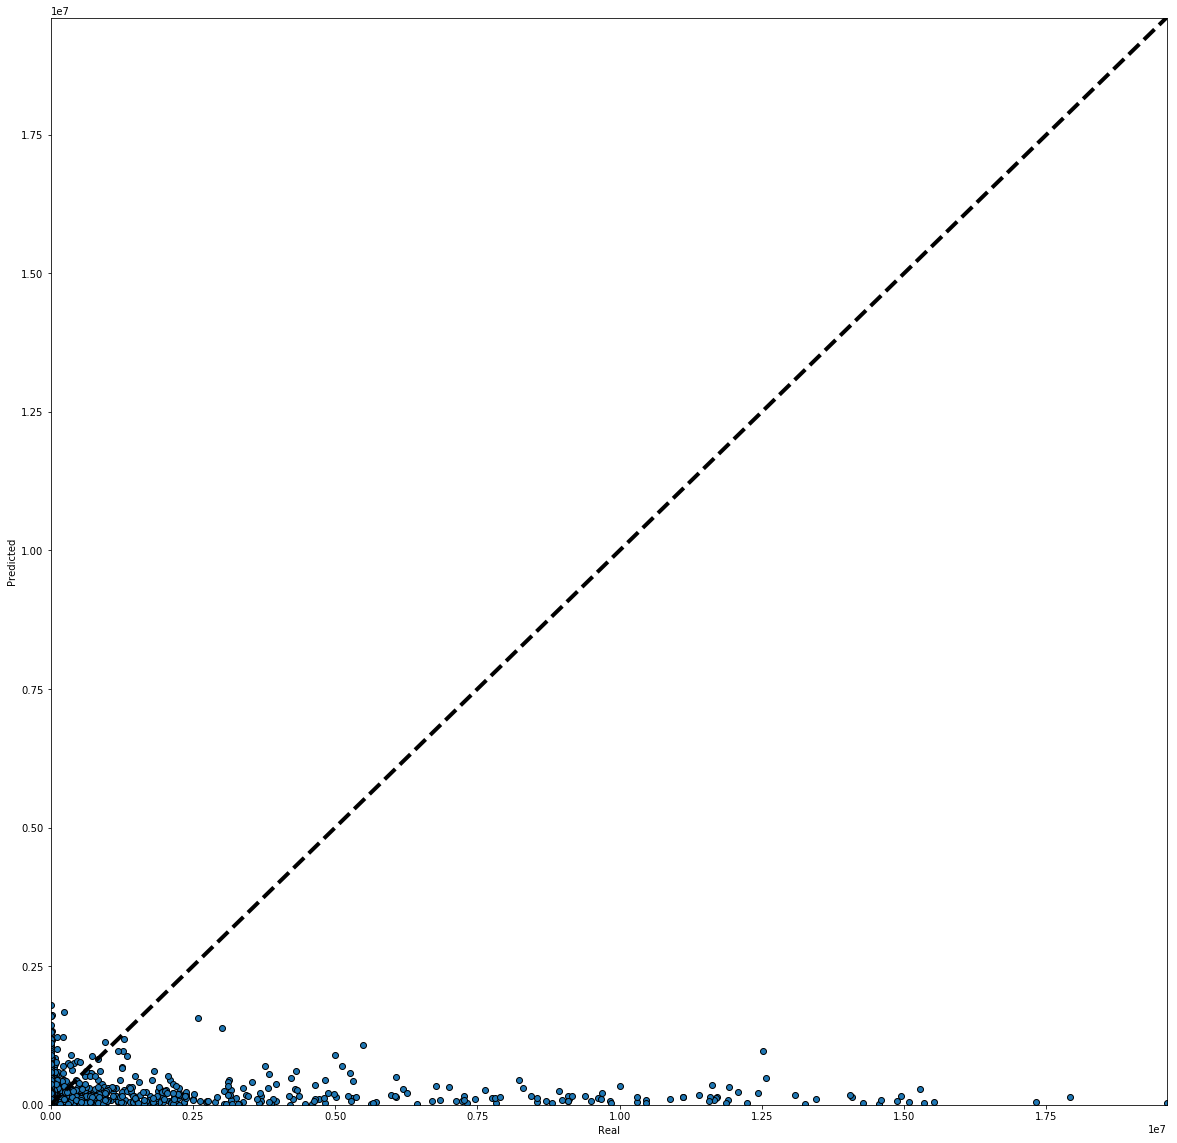

In [39]:
y_test = pd.Series(dill.load(open('data/ytest.pkd', 'r')))
pred = dill.load(open('data/pred.pkd', 'r'))
thrh = y_test.max()
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(y_test, pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), thrh], [y_test.min(), thrh], 'k--', lw=4)
ax.set_xlim([y_test.min(), thrh])
ax.set_ylim([y_test.min(), thrh])
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.savefig('pred_real.png')
plt.show()